In [1]:
import drjit as dr
import mitsuba as mi

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS

mi.set_variant('cuda_ad_rgb')

In [2]:
integrator = {
    'type': 'direct_reparam',
}

In [3]:
from mitsuba.scalar_rgb import Transform4f as T

def reset_scene():
    return mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, 2),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'fov': 60,
        'film': {
            'type': 'hdrfilm',
            'width': 64,
            'height': 64,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    'wall': {
        'type': 'obj',
        'filename': '../scenes/meshes/rectangle.obj',
        'to_world': T.translate([0, 0, -2]).scale(2.0),
        'face_normals': True,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
        }
    },
    'bunny': {
        'type': 'ply',
        'filename': '../scenes/meshes/bunny.ply',
        'to_world': T.scale(6.5),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) },
        },
    },
    'light': {
        'type': 'obj',
        'filename': '../scenes/meshes/sphere.obj',
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
        },
        'to_world': T.translate([2.5, 2.5, 7.0]).scale(0.25)
    }
})

scene = reset_scene()

In [4]:
img_ref = mi.render(scene, seed=0, spp=1024)

mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [5]:
params = mi.traverse(scene)
initial_vertex_positions = dr.unravel(mi.Point3f, params['bunny.vertex_positions'])

In [6]:
def update_scene(params, trans_x, trans_y, angle):
    trafo = mi.Transform4f.translate([trans_x, trans_y, 0.0]).rotate([0, 1, 0], angle * 100.0)

    params['bunny.vertex_positions'] = dr.ravel(trafo @ initial_vertex_positions)
    params.update()

def apply_transformation(params, opt):
    opt['trans'] = dr.clamp(opt['trans'], -1.0, 1.0)
    opt['angle'] = dr.clamp(opt['angle'], -1.0, 1.0)
    return update_scene(params, opt['trans'].x, opt['trans'].y, opt['angle'])

In [7]:
opt = mi.ad.Adam(lr=0.025)
opt['angle'] = mi.Float(0.25)
opt['trans'] = mi.Point2f(0.8, -0.8)
apply_transformation(params, opt)
img_init = mi.render(scene, seed=0, spp=1024)
mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [8]:
iteration_count = 300
spp = 16

In [9]:
loss_hist = []
for it in range(iteration_count):
    # Apply the mesh transformation
    apply_transformation(params, opt)

    # Perform a differentiable rendering
    img = mi.render(scene, params, seed=it, spp=spp)

    # Evaluate the objective function
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    loss_hist.append(loss)
    print(f"Iteration {it:02d}: error={loss[0]:6f}, angle={opt['angle'][0]:.4f}, trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}]", end='\r')

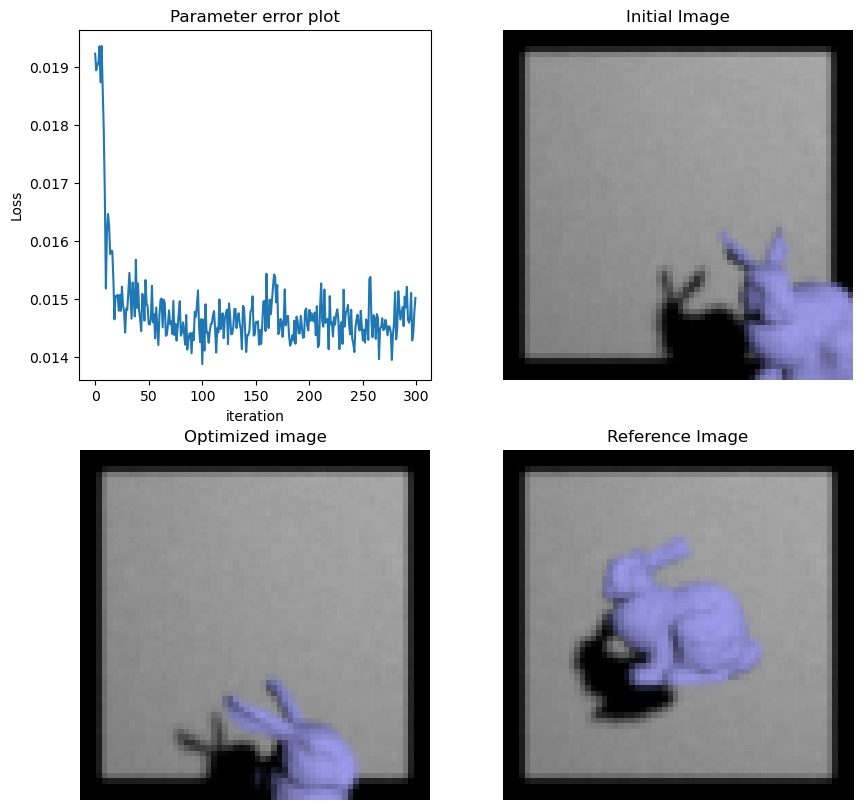

In [10]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

# Global optimization

In [11]:
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
import numpy as np

class ThetaOpt(Problem):
    def __init__(self, ref_img, loss_fn, spp):
        self.ref_img = ref_img
        self.loss_fn = loss_fn
        self.spp = spp
        super().__init__(n_var=3, n_obj=1, n_constr=0, xl=-1.0, xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        nb_samples = x.shape[0]
        out["F"] = np.array([0.0]*nb_samples)
        for i in range(nb_samples):
            scene = reset_scene()
            params = mi.traverse(scene)
            update_scene(params, to_float(x[i, 0]), to_float(x[i, 1]), to_float(x[i, 2]))
            image = mi.render(scene, params, seed=i, spp=self.spp)
            loss = to_float(self.loss_fn(image, self.ref_img))
            out["F"][i] = loss
    
    def show_res(self, x, spp=None):
        if spp is None:
            spp = self.spp
        scene = reset_scene()
        params = mi.traverse(scene)
        update_scene(params, to_float(x[0]), to_float(x[1]), to_float(x[2]))
        image = mi.render(scene, params, seed=0, spp=spp)
        return image_to_bm(image)

In [12]:
from pymoo.algorithms.soo.nonconvex.ga import GA

problem = ThetaOpt(img_ref, mse, 16)
algorithm = GA(pop_size=20, eliminate_duplicates=True)
res_ga = minimize(problem, algorithm, ('n_gen', 10), seed=0, verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 |  0.0163645855 |  0.0081215557
     2 |       40 |  0.0134072097 |  0.0077979425
     3 |       60 |  0.0108646270 |  0.0065643452
     4 |       80 |  0.0086768800 |  0.0065643452
     5 |      100 |  0.0073901682 |  0.0046874909
     6 |      120 |  0.0066579278 |  0.0046874909
     7 |      140 |  0.0056036660 |  0.0044320975
     8 |      160 |  0.0050561321 |  0.0044204788
     9 |      180 |  0.0047575911 |  0.0040112315
    10 |      200 |  0.0044590113 |  0.0039872844


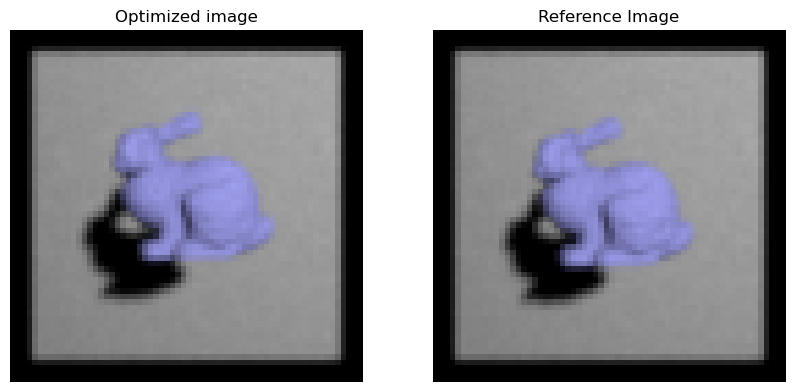

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(problem.show_res(res_ga.X, spp=1024))
axs[0].axis('off')
axs[0].set_title('Optimized image')

axs[1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1].axis('off')
axs[1].set_title('Reference Image');

## Global optimization + gradient descent

In [25]:
def cross_pair(a, b, cross_rate=0.5):
    nb_cross = int(cross_rate * a.shape[0])
    cross_points = list(np.random.choice(a.shape[0], nb_cross, replace=False))
    a, b = np.array(a), np.array(b)
    a[cross_points, ...], b[cross_points, ...] = b[cross_points, ...], a[cross_points, ...]
    return a, b

def mutate(a, mut_rate=0.1):
    if isinstance(a, dict):
        return {key: mutate(val, mut_rate) for (key, val) in a.items()}
    else:
        return np.clip(np.array(a) + np.random.normal(0, mut_rate, a.shape), 0, 1)

In [36]:
from pymoo.operators.sampling.rnd import FloatRandomSampling

def ga_opt(problem: Problem, pop_size = 10, selection_rate=0.3, mut_rate=0.03, nb_gen = 10, nb_grad_iter = 10, spp=32):
    best_image_gen = []
    best_params_gen = []

    sampling = FloatRandomSampling()
    param_values = sampling(problem, pop_size).get("X")

    for gen in range(nb_gen):
        print(f"Generation {gen+1}/{nb_gen}")

        losses = []
        new_param_values = []
        img_end = []
        for i, value in enumerate(param_values):
            opt = mi.ad.Adam(lr=0.025)
            opt['trans'] = mi.Point2f(value[0], value[1])
            opt['angle'] = mi.Float(value[2])
            scene = reset_scene()
            params = mi.traverse(scene)
            
            for it in range(nb_grad_iter):
                print(f"Sample {i+1}/{pop_size}\tIteration {it+1}/{nb_grad_iter}", end='\r')
                apply_transformation(params, opt)
                img = mi.render(scene, params, seed=i*nb_grad_iter+it, spp=spp)
                loss = dr.sum(dr.sqr(img - img_ref)) / len(img)
                dr.backward(loss)
                opt.step()
            losses.append(to_float(loss))
            new_param_values.append([to_float(opt["trans"].x), to_float(opt["trans"].y), to_float(opt["angle"])])
            img_end.append(img)
        print()


        # handmade genetic algorithm to select the best samples for the next generation
        losses = np.array(losses)
        param_values = np.array(new_param_values)
        idx = np.argsort(losses)

        # print best loss
        print(f"Best loss: {losses[idx[0]]}")

        best_image_gen.append(image_to_bm(img_end[idx[0]]))

        # select the best samples for the next generation and cross them + mutate them
        best_values = [param_values[i] for i in idx[:max(int(pop_size*selection_rate), 1)]]
        new_param_values = []
        for i in range(pop_size):
            a = best_values[np.random.randint(len(best_values))]
            b = best_values[np.random.randint(len(best_values))]
            a, b = cross_pair(a, b)
            a = mutate(a, mut_rate)
            new_param_values.append(a)
        param_values = new_param_values
    
    return best_image_gen

res = ga_opt(problem, pop_size=10, selection_rate=0.3, mut_rate=0.03, nb_gen=3, nb_grad_iter=3, spp=16)

Generation 1/3
Sample 10/10	Iteration 3/3
Best loss: 0.010709382593631744
Generation 2/3
Sample 10/10	Iteration 3/3
Best loss: 0.0026295785792171955
Generation 3/3
Sample 10/10	Iteration 3/3
Best loss: 0.0026344559155404568


In [37]:
def plot(
    images_bm, size_factor=3
):
    fig, ax = plt.subplots(
        ncols=1,
        nrows=len(images_bm),
        figsize=(8, size_factor * len(images_bm)),
        squeeze=False,
    )
    for i, img in enumerate(images_bm):
        ax[i, 0].imshow(img, vmin=0, vmax=1)
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
    ax[0, 0].set_title("Rendering", weight="bold", size=14)
    plt.tight_layout()
    plt.show()

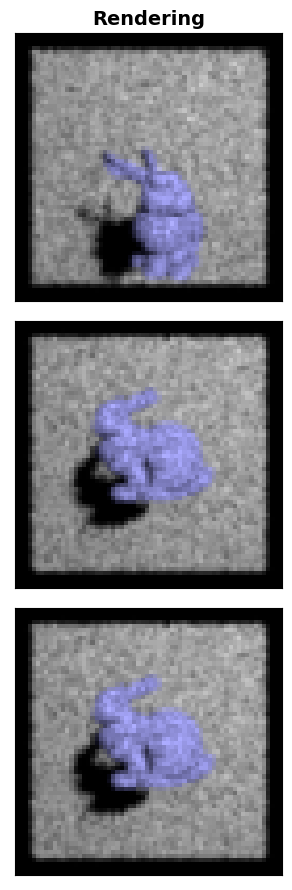

In [38]:
plot(res)